# Plotting the crossvalidation misclassification error rates and training misclassification error rate

In [1]:
import numpy as np
import pandas as pd
import csv
import os
import pprint
np.random.seed(12345)
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from random import random
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold


In [2]:
#--- constants(do not change) ---
kFold = 10
iters = 100

In [3]:
#--- data preparation utilities ---

pp = pprint.PrettyPrinter(indent=4)

# popularity detector
def popular(s):
    return 1 if s>1400 else 0

#drop url and time, standardize everything else
def prepare(data):
    data_no_url_time = data.drop(['Unnamed: 0','url',' timedelta'],axis = 1)
    scaled_data = data_no_url_time.copy()
    for column in data_no_url_time.columns:
        if column!=' shares':
            scaled_data[column] = preprocessing.scale(data_no_url_time[column])
    scaled_data[' popularity'] = scaled_data[' shares'].apply(popular)
    std_data = scaled_data.drop([' shares'],axis=1)
    return std_data

#takes dataframes containing both predictor and the output and separates them
def make_train_test(train, test, lastColumnTrain, columnOutput):
    x_train = train.loc[:,:lastColumnTrain]
    y_train = train.loc[:,columnOutput]
    x_test = test.loc[:,:lastColumnTrain]
    y_test = test.loc[:,columnOutput]
    return x_train, y_train, x_test, y_test


In [4]:
data = pd.read_csv('/Users/rigel/Course Docs/Fall-2018/MachineLearning/project/dataset/OnlineNewsPopularity/OnlineNewsPopularitysample.csv') 
std_data=prepare(data)

In [5]:
# def make_plot (title, train_scores, test_scores):   
#     plt.plot(train_scores, test_scores)
#     plt.title(title)
#     plt.xlabel("Training error")
#     plt.ylabel("Test Error")
#     plt.show()


# # classifier = {
# #          #'RADIAL SVM': SVC,
# #          'LASSO': Lasso,
# #          'ELASTIC NET': ElasticNet,
# #          'RIDGE': Ridge
# #          }

# predictors = std_data.loc[:,:' abs_title_sentiment_polarity']
# output = std_data.loc[:,' popularity']

# train_scores, test_scores = validation_curve(Lasso(), 
#                                              predictors,
#                                              output, 
#                                              param_name='alpha', 
#                                              param_range=alpha_range,
#                                              cv=kFold,
#                                              n_jobs=-1)
# print (train_scores)
# print (test_scores)
# make_plot("Lasso", train_scores, test_scores)


In [6]:
misc_rates = {}
alpha_range = np.logspace(-5,8,100)


def cv_func(clf_name, alpha, x_train, y_train, x_test):
    y_train = np.transpose(y_train.values)
    x_train = x_train.values
    kf = KFold(n_splits=kFold)
    train_errors = []
    test_errors = []
    for train_index, test_index in kf.split(x_train):
        X_train, X_test = x_train[train_index], x_train[test_index]
        Y_train, Y_test = y_train[train_index], y_train[test_index]
        classifiers = {
            'lasso': Lasso(alpha=alpha, max_iter=100000),
            'ridge': RidgeClassifier(alpha=alpha, max_iter=100000),
            'elasticnet': ElasticNet(alpha=alpha, max_iter=100000)
        }
        clf = classifiers[clf_name]
        clf.fit(X_train, Y_train)
        Y_pred_test = [1 if p > 0.5 else 0 for p in clf.predict(X_test)]
        Y_pred_train = [1 if p > 0.5 else 0 for p in clf.predict(X_train)]
        train_errors.append(1.0 - accuracy_score(Y_train, Y_pred_train))
        test_errors.append(1.0- accuracy_score(Y_test, Y_pred_test))
    return [np.array(train_errors).mean(), np.array(test_errors).mean()]

def run_model(data, clf_name, alpha_range):
    lastPredictor = ' abs_title_sentiment_polarity'
    columnOutput = ' popularity'
    p = data.loc[:,:lastPredictor].columns.size
    n = len(data.index)
    learning_set_sizes = {'2p': 2*p, '10p': 10*p}
    misclassification_rates = {
        'train': {
            '2p': [],
            '10p': []
        },
        'test': {
            '2p': [],
            '10p': []
        }
    }
    for size_case in learning_set_sizes:
        size = learning_set_sizes[size_case]
        train_set,test_set = train_test_split(data, test_size= 1.0*size/n, random_state=0)
        x_train, y_train, x_test, y_test = make_train_test(train_set, test_set, lastPredictor, columnOutput)
        for alpha in alpha_range:
            print ("alpha = ", alpha, "case = ", size_case)
            scores = cv_func(clf_name, alpha, x_train, y_train, x_test)
            misclassification_rates['train'][size_case].append(scores[0])
            misclassification_rates['test'][size_case].append(scores[1])
    return misclassification_rates

misc_rates['lasso'] = run_model(std_data, 'lasso', alpha_range)
misc_rates['ridge'] = run_model(std_data, 'ridge', alpha_range)
misc_rates['elasticnet'] = run_model(std_data, 'elasticnet', alpha_range)

print(misc_rates)

alpha =  1e-05 case =  2p
alpha =  1.35304777458e-05 case =  2p
alpha =  1.8307382803e-05 case =  2p
alpha =  2.47707635599e-05 case =  2p
alpha =  3.35160265094e-05 case =  2p
alpha =  4.53487850813e-05 case =  2p
alpha =  6.13590727341e-05 case =  2p
alpha =  8.30217568132e-05 case =  2p
alpha =  0.000112332403298 case =  2p
alpha =  0.000151991108295 case =  2p
alpha =  0.000205651230835 case =  2p
alpha =  0.000278255940221 case =  2p
alpha =  0.000376493580679 case =  2p
alpha =  0.000509413801482 case =  2p
alpha =  0.000689261210435 case =  2p
alpha =  0.000932603346883 case =  2p
alpha =  0.00126185688307 case =  2p
alpha =  0.00170735264747 case =  2p
alpha =  0.00231012970008 case =  2p
alpha =  0.00312571584969 case =  2p
alpha =  0.00422924287439 case =  2p
alpha =  0.00572236765935 case =  2p
alpha =  0.00774263682681 case =  2p
alpha =  0.0104761575279 case =  2p
alpha =  0.0141747416293 case =  2p
alpha =  0.0191791026167 case =  2p
alpha =  0.025950242114 case =  2p
alp

In [7]:
gamma_range = np.logspace(-1,2,10)
c_range = np.logspace(-1,2,10)

def cv_func_2(c, gamma, x_train, y_train, x_test):
    y_train = np.transpose(y_train.values)
    x_train = x_train.values
    kf = KFold(n_splits=kFold)
    train_errors = []
    test_errors = []
    for train_index, test_index in kf.split(x_train):
        X_train, X_test = x_train[train_index], x_train[test_index]
        Y_train, Y_test = y_train[train_index], y_train[test_index]
        clf = SVC(C=c, gamma=gamma)
        clf.fit(X_train, Y_train)
        Y_pred_test = [1 if p > 0.5 else 0 for p in clf.predict(X_test)]
        Y_pred_train = [1 if p > 0.5 else 0 for p in clf.predict(X_train)]
        train_errors.append(1.0 - accuracy_score(Y_train, Y_pred_train))
        test_errors.append(1.0- accuracy_score(Y_test, Y_pred_test))
    return [np.array(train_errors).mean(), np.array(test_errors).mean()]

def run_model_svm(data, c_range, gamma_range):
    lastPredictor = ' abs_title_sentiment_polarity'
    columnOutput = ' popularity'
    p = data.loc[:,:lastPredictor].columns.size
    n = len(data.index)
    learning_set_sizes = {'2p': 2*p, '10p': 10*p}
    misclassification_rates = {
        'train': {
            '2p': [],
            '10p': []
        },
        'test': {
            '2p': [],
            '10p': []
        }
    }
    for size_case in learning_set_sizes:
        size = learning_set_sizes[size_case]
        train_set,test_set = train_test_split(data, test_size= 1.0*size/n, random_state=0)
        x_train, y_train, x_test, y_test = make_train_test(train_set, test_set, lastPredictor, columnOutput)
        for c in c_range:
            for gamma in gamma_range:
                print ("c = ", c, "gamma = ", gamma, " size = ", size_case)
                scores = cv_func_2(c, gamma, x_train, y_train, x_test)
                misclassification_rates['train'][size_case].append(scores[0])
                misclassification_rates['test'][size_case].append(scores[1])
    return misclassification_rates

misc_rates['svm'] = run_model_svm(std_data, c_range, gamma_range)
print (misc_rates['svm'])

c =  0.1 gamma =  0.1  size =  2p
c =  0.1 gamma =  0.215443469003  size =  2p
c =  0.1 gamma =  0.464158883361  size =  2p
c =  0.1 gamma =  1.0  size =  2p
c =  0.1 gamma =  2.15443469003  size =  2p
c =  0.1 gamma =  4.64158883361  size =  2p
c =  0.1 gamma =  10.0  size =  2p
c =  0.1 gamma =  21.5443469003  size =  2p
c =  0.1 gamma =  46.4158883361  size =  2p
c =  0.1 gamma =  100.0  size =  2p
c =  0.215443469003 gamma =  0.1  size =  2p
c =  0.215443469003 gamma =  0.215443469003  size =  2p
c =  0.215443469003 gamma =  0.464158883361  size =  2p
c =  0.215443469003 gamma =  1.0  size =  2p
c =  0.215443469003 gamma =  2.15443469003  size =  2p
c =  0.215443469003 gamma =  4.64158883361  size =  2p
c =  0.215443469003 gamma =  10.0  size =  2p
c =  0.215443469003 gamma =  21.5443469003  size =  2p
c =  0.215443469003 gamma =  46.4158883361  size =  2p
c =  0.215443469003 gamma =  100.0  size =  2p
c =  0.464158883361 gamma =  0.1  size =  2p
c =  0.464158883361 gamma =  0.2154

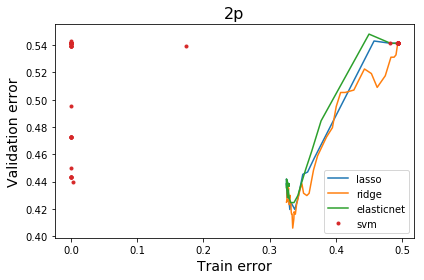

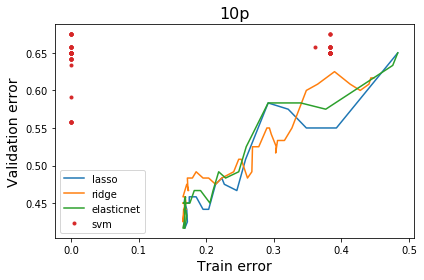

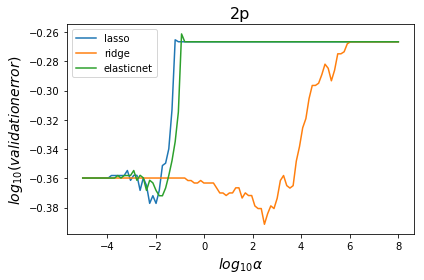

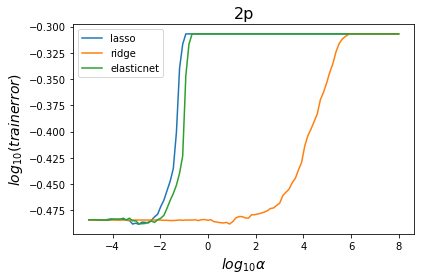

In [8]:
plt.plot((misc_rates['lasso']['train']['2p']), (misc_rates['lasso']['test']['2p']), '-', label='lasso')
plt.plot((misc_rates['ridge']['train']['2p']), (misc_rates['ridge']['test']['2p']), '-', label='ridge')
plt.plot((misc_rates['elasticnet']['train']['2p']), (misc_rates['elasticnet']['test']['2p']), '-', label='elasticnet')
plt.plot((misc_rates['svm']['train']['2p']), (misc_rates['svm']['test']['2p']), '.', label='svm')
plt.legend()
plt.title('2p', fontsize=16)
plt.xlabel('Train error', fontsize=14)
plt.ylabel('Validation error',fontsize=14)
plt.tight_layout()
plt.savefig('error-comparison-2p.png', dpi=1200)
plt.show()

plt.plot((misc_rates['lasso']['train']['10p']), (misc_rates['lasso']['test']['10p']), '-', label='lasso')
plt.plot((misc_rates['ridge']['train']['10p']), (misc_rates['ridge']['test']['10p']), '-', label='ridge')
plt.plot((misc_rates['elasticnet']['train']['10p']), (misc_rates['elasticnet']['test']['10p']), '-', label='elasticnet')
plt.plot((misc_rates['svm']['train']['10p']), (misc_rates['svm']['test']['10p']), '.', label='svm')
plt.legend()
plt.title('10p', fontsize=16)
plt.xlabel('Train error',fontsize=14)
plt.ylabel('Validation error',fontsize=14)
plt.tight_layout()
plt.savefig('error-comparison-10p.png', dpi=1200)
plt.show()

plt.plot(np.log10(alpha_range),np.log10(misc_rates['lasso']['test']['2p']), label='lasso')
plt.plot(np.log10(alpha_range),np.log10(misc_rates['ridge']['test']['2p']), label='ridge')
plt.plot(np.log10(alpha_range),np.log10(misc_rates['elasticnet']['test']['2p']), label='elasticnet')
plt.title('2p', fontsize=16)
plt.xlabel(r'$log_{10}\alpha$',fontsize=14)
plt.ylabel('$log_{10}(validationerror)$',fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig('alpha-dependence-validation-2p.png', dpi=1200)
plt.show()

plt.plot(np.log10(alpha_range), np.log10(misc_rates['lasso']['train']['2p']), label='lasso')
plt.plot(np.log10(alpha_range), np.log10(misc_rates['ridge']['train']['2p']), label='ridge')
plt.plot(np.log10(alpha_range), np.log10(misc_rates['elasticnet']['train']['2p']), label='elasticnet')
plt.title('2p', fontsize=16)
plt.xlabel(r'$log_{10}\alpha$',fontsize=14)
plt.ylabel('$log_{10}(trainerror)$',fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig('alpha-dependence-train-2p.png', dpi=1200)
plt.show()